# Is the initial Mtb load correlated to growth

Using the ground-truth checked tracks from the control (3,5) example.

In [8]:
import os
import btrack
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from macrohet import dataio, tools
from tqdm.auto import tqdm
from scipy import stats
colors = sns.set_palette('PiYG')
track_scale_factor = 5.04

def animated_plot_glimpse_maker(images, cell_ID, df, crop_size=None, track_scale_factor=5.04):
    # Extract xy coordinates and transpose for python and area from the cell information
    y_coord, x_coord, area, t = df.loc[df['Cell_ID'] == cell_ID, ['x', 'y', 'Area', 'Time_hours']].values[0]
    
    # Scale according to tracking shrinkage
    y_coord, x_coord = y_coord * track_scale_factor, x_coord * track_scale_factor
    
    if not crop_size:
        # Calculate the side length for cropping based on the square root of the area
        side_length = int(np.sqrt(area)) * 2
    
    # Calculate the cropping boundaries
    x_start = int(x_coord - side_length/2)
    x_end = int(x_coord + side_length/2)
    y_start = int(y_coord - side_length/2)
    y_end = int(y_coord + side_length/2)
    
    # Pad the boundaries if they exceed the image dimensions
    if x_start < 0:
        x_pad = abs(x_start)
        x_start = 0
    else:
        x_pad = 0
    
    if x_end > images.shape[2]:
        x_pad_end = x_end - images.shape[2]
        x_end = images.shape[2]
    else:
        x_pad_end = 0
    
    if y_start < 0:
        y_pad = abs(y_start)
        y_start = 0
    else:
        y_pad = 0
    
    if y_end > images.shape[3]:
        y_pad_end = y_end - images.shape[3]
        y_end = images.shape[3]
    else:
        y_pad_end = 0
    
    # Crop the image
    cropped_image = images[t, :, x_start:x_end, y_start:y_end]
    
    # Pad the cropped image if necessary
    cropped_image = np.pad(cropped_image, ((0, 0), (x_pad, x_pad_end), (y_pad, y_pad_end)), mode='constant')
    
    # Create an empty RGB image with the same shape as the input image
    rgb_image = np.zeros((cropped_image.shape[1], cropped_image.shape[2], 3), dtype=np.uint8)

    # Assign the first channel to the green channel of the RGB image
    rgb_image[:, :, 1] = cropped_image[0]

    # Assign the second channel to the red and blue channels of the RGB image to create magenta
    rgb_image[:, :, 0] = cropped_image[1]
    rgb_image[:, :, 2] = cropped_image[1]
    
    # Return the cropped RGB image
    return rgb_image

In [ ]:
x, y, c

In [26]:
images

,Array,Chunk
Bytes,5.11 GiB,7.75 MiB
Shape,"(75, 2, 6048, 6048)","(1, 2, 2016, 2016)"
Count,17550 Tasks,675 Chunks
Type,uint8,numpy.ndarray


In [24]:
cropped_image[0]

dask.array<getitem, shape=(6048, 6048), dtype=uint8, chunksize=(2016, 2016), chunktype=numpy.ndarray>

In [25]:
cropped_image[1]

dask.array<getitem, shape=(6048, 6048), dtype=uint8, chunksize=(2016, 2016), chunktype=numpy.ndarray>

### Load metadata

In [14]:
base_dir = '/mnt/DATA/macrohet/'
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Load all tracks

In [3]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{row,column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/06/02 03:32:58 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/06/02 03:32:58 PM] Loading tracks/obj_type_1
[INFO][2023/06/02 03:32:58 PM] Loading LBEP/obj_type_1
[INFO][2023/06/02 03:32:58 PM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/06/02 03:32:59 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5
[INFO][2023/06/02 03:32:59 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/02 03:32:59 PM] Loading tracks/obj_type_1
[INFO][2023/06/02 03:32:59 PM] Loading LBEP/obj_type_1
[INFO][2023/06/02 03:32:59 PM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/06/02 03:32:59 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5
[INFO][2023/06/02 03:32:59 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2023/06/02 03:32:59 PM] Loading tracks/obj_type_1
[INFO]

[INFO][2023/06/02 03:33:14 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5
[INFO][2023/06/02 03:33:14 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5...
[INFO][2023/06/02 03:33:14 PM] Loading tracks/obj_type_1
[INFO][2023/06/02 03:33:14 PM] Loading LBEP/obj_type_1
[INFO][2023/06/02 03:33:15 PM] Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)
[INFO][2023/06/02 03:33:15 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5
[INFO][2023/06/02 03:33:15 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/06/02 03:33:15 PM] Loading tracks/obj_type_1
[INFO][2023/06/02 03:33:15 PM] Loading LBEP/obj_type_1
[INFO][2023/06/02 03:33:15 PM] Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)
[INFO][2023/06/02 03:33:16 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5
[INFO][2023/06/02 03:33:16 PM] Opening HDF file: /mnt/DATA/macrohe

### Pick set of tracks of interest

In [15]:
row, column = 3, 5
# tracks = tracks_dict[(row, column)]

### Load ground truth labels for tracks

In [5]:
gt_track_dict_fn = '/mnt/DATA/macrohet/upstream_development/tracking/tracking_performance/3,5/ground_truth_tracks/(3, 5)_track_assessment.json'
# Load the JSON data from the file
with open(gt_track_dict_fn, 'r') as file:
    gt_track_dict = json.load(file)

In [6]:
gt_track_dict

{'425': True,
 '694': True,
 '403': False,
 '427': True,
 '453': False,
 '217': True,
 '1002': False,
 '1893': False,
 '1986': False,
 '2192': False,
 '401': True,
 '412': False,
 '2499': False,
 '1446': False,
 '1003': True,
 '790': False,
 '1552': False,
 '2862': False,
 '432': True,
 '456': True,
 '461': True,
 '416': True,
 '1892': False,
 '430': True,
 '1226': True,
 '1783': True,
 '429,2818': 'Link',
 '431': True,
 '407': True,
 '2675,404': 'Link',
 '398': True,
 '423': True,
 '424': True,
 '428': False,
 '418': False,
 '411': False,
 '411,1683': 'Link',
 '1058': False,
 '466': True,
 '465': True,
 '397': True,
 '426': True,
 '419': True,
 '1735': True,
 '420': True,
 '421': True,
 '802': True,
 '455': False,
 '406': False,
 '410': True,
 '411,1118': 'Link',
 '1118': True,
 '1114,2130': 'Link',
 '414': True,
 '459': True,
 '2234': True,
 '470': True,
 '437': True,
 '1649,2453': 'Link',
 '2453,3126': 'Link',
 '444': True,
 '865': False,
 '441': True,
 '318': False,
 '2952': False,

In [7]:
true_IDs = [int(ID) for ID, status in gt_track_dict.items() if status is True]

### Filter true tracks

In [8]:
true_tracks = [t for t in tracks if t.ID in true_IDs]

In [9]:
true_tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,area,major_axis_length,Infected,mean_intensity,orientation,minor_axis_length
0,423,0,723.909912,33.010132,0.000000,423,423,5,0,False,23203.0,344.046997,1.0,"(3,) array",-0.105442,87.624420
1,423,1,727.771362,38.211437,0.000000,423,423,5,0,False,25659.0,410.356964,1.0,"(3,) array",-0.105384,95.545296
2,423,2,730.887634,26.283424,0.000000,423,423,5,0,False,19483.0,281.636444,1.0,"(3,) array",-0.172310,89.392372
3,423,3,732.147583,27.895367,0.000000,423,423,5,0,False,22840.0,325.991333,1.0,"(3,) array",-0.172292,92.556488
4,423,4,730.891357,33.019173,0.000000,423,423,5,0,False,23224.0,373.707001,1.0,"(3,) array",-0.152742,80.582886
5,423,5,731.606384,30.630995,0.000000,423,423,5,0,False,21159.0,351.986481,1.0,"(3,) array",-0.151112,78.869858
6,423,6,732.788086,30.744682,0.000000,423,423,5,0,False,21750.0,358.099487,1.0,"(3,) array",-0.169930,79.728958
7,423,7,733.528625,27.149408,0.000000,423,423,5,0,False,15457.0,294.958893,0.0,"(3,) array",-0.195798,67.987579
8,423,8,733.524414,32.480957,0.000000,423,423,5,0,False,21431.0,385.717529,1.0,"(3,) array",-0.201907,73.575928
9,423,9,735.238953,29.900726,0.000000,423,423,5,0,False,22385.0,409.529633,1.0,"(3,) array",-0.251289,79.070381


### add all this information to cumulative df

In [10]:
assay_layout.loc[(3,5)]

Strain               WT
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (3, 5), dtype: object

In [42]:
### list of track info dfs
dfs = list()
### iterate over full length tracks
for track in tqdm(true_tracks):
    ### get info for assay layout
    info = assay_layout.loc[(3,5)]
    ### compile single track dictionary of info
    d = {'Time (hours)':track['t'], 
         'x':track['x'],
         'y':track['y'],
         'x scaled':[track['x'][i]*5.04 for i, x in enumerate(track['x'])],
         'y scaled':[track['y'][i]*5.04 for i, y in enumerate(track['y'])],
         'Infection status':['Infected' if track['Infected'][i] == 1 else 'Uninfected' for i in range(len(track['Infected']))],
         'Initial infection status':['Infected' if track['Infected'][0] == 1 else 'Uninfected' for i in range(len(track['Infected']))], 
         'Final infection status':['Infected' if track['Infected'][-1] == 1 else 'Uninfected' for i in range(len(track['Infected']))], 
         'Area':track['area'], 
         'Intracellular mean Mtb content':track['mean_intensity'][:, 1],
         'Intracellular thresholded Mtb content':track['mean_intensity'][:, 2],
         'Macroph. GFP expression':track['mean_intensity'][:, 0],
         'delta Mtb': [track['mean_intensity'][-1, 2] - track['mean_intensity'][0, 2] for i in range(len(track['t']))],
         'delta Mtb (fold-change)': [(track['mean_intensity'][-1, 2] - track['mean_intensity'][0, 2])/track['mean_intensity'][0, 2] for i in range(len(track['t']))],
         'Eccentricity':np.sqrt(1-((track['minor_axis_length']**2)/(track['major_axis_length']**2))),
         'MSD': [tools.euc_dist(track['x'][i-1], 
                                track['y'][i-1], 
                                track['x'][i], 
                                track['y'][i]) 
                  if i != 0 else 0
                  for i in range(0, len(track))],
         'Strain':[info['Strain'] for i in range(len(track['t']))], 
         'Compound':[info['Compound'] for i in range(len(track['t']))], 
         'Concentration':[info['ConcentrationEC'] for i in range(len(track['t']))], 
         'Cell ID':[track.ID for i in range(len(track['t']))],
         'Acquisition ID':[(3,5) for i in range(len(track['t']))], 
         'Unique ID': [f'{track.ID}.{row}.{column}' for i in range(len(track['t']))]}
    ### append df to list of dfs
    dfs.append(pd.DataFrame(d))
### concat single track dfs into big df
df = pd.concat(dfs, ignore_index=True)
df

  0%|          | 0/384 [00:00<?, ?it/s]

/tmp/ipykernel_942080/2392244345.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  'delta Mtb (fold-change)': [(track['mean_intensity'][-1, 2] - track['mean_intensity'][0, 2])/track['mean_intensity'][0, 2] for i in range(len(track['t']))],
/tmp/ipykernel_942080/2392244345.py:21: RuntimeWarning: invalid value encountered in double_scalars
  'delta Mtb (fold-change)': [(track['mean_intensity'][-1, 2] - track['mean_intensity'][0, 2])/track['mean_intensity'][0, 2] for i in range(len(track['t']))],
/tmp/ipykernel_942080/2392244345.py:21: RuntimeWarning: invalid value encountered in float_scalars
  'delta Mtb (fold-change)': [(track['mean_intensity'][-1, 2] - track['mean_intensity'][0, 2])/track['mean_intensity'][0, 2] for i in range(len(track['t']))],
/tmp/ipykernel_942080/2392244345.py:21: RuntimeWarning: divide by zero encountered in float_scalars
  'delta Mtb (fold-change)': [(track['mean_intensity'][-1, 2] - track['mean_intensity'][0, 2])/track['mean_intensity'][0, 2

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,Intracellular thresholded Mtb content,Macroph. GFP expression,delta Mtb,delta Mtb (fold-change),Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,723.909912,33.010132,3648.505957,166.371064,Infected,Infected,Infected,23203.0,357.706421,4.649916,887.426208,26.188255,5.631984,0.967023,0.000000,WT,CTRL,EC0,423,"(3, 5)",423.3.5
1,1,727.771362,38.211437,3667.967666,192.585644,Infected,Infected,Infected,25659.0,363.283356,8.909817,1602.132080,26.188255,5.631984,0.972516,6.477992,WT,CTRL,EC0,423,"(3, 5)",423.3.5
2,2,730.887634,26.283424,3683.673677,132.468459,Infected,Infected,Infected,19483.0,355.947845,7.153211,1095.762207,26.188255,5.631984,0.948291,12.328367,WT,CTRL,EC0,423,"(3, 5)",423.3.5
3,3,732.147583,27.895367,3690.023818,140.592648,Infected,Infected,Infected,22840.0,354.730682,6.231918,953.190063,26.188255,5.631984,0.958847,2.045930,WT,CTRL,EC0,423,"(3, 5)",423.3.5
4,4,730.891357,33.019173,3683.692441,166.416630,Infected,Infected,Infected,23224.0,356.257538,8.091026,995.672668,26.188255,5.631984,0.976475,5.275556,WT,CTRL,EC0,423,"(3, 5)",423.3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22813,70,11.404111,928.200378,57.476719,4678.129907,Infected,Uninfected,Infected,15506.0,437.055450,116.548302,2788.570068,94.672058,inf,0.863828,2.616289,WT,CTRL,EC0,3380,"(3, 5)",3380.3.5
22814,71,6.907405,927.155212,34.813321,4672.862271,Uninfected,Uninfected,Infected,5796.0,342.371277,0.000000,2744.147217,94.672058,inf,0.853696,4.616572,WT,CTRL,EC0,3380,"(3, 5)",3380.3.5
22815,72,9.546013,927.389832,48.111905,4674.044751,Infected,Uninfected,Infected,12314.0,399.863647,73.398003,2788.622559,94.672058,inf,0.866145,2.649018,WT,CTRL,EC0,3380,"(3, 5)",3380.3.5
22816,73,8.320204,924.214172,41.933827,4658.039429,Infected,Uninfected,Infected,10518.0,407.069397,79.124168,2974.992676,94.672058,inf,0.803451,3.404030,WT,CTRL,EC0,3380,"(3, 5)",3380.3.5


In [12]:
import re

# Remove non-letter characters and replace spaces with underscores in column names
df.columns = [re.sub(r'[^a-zA-Z ]', '', col).replace(' ', '_') for col in df.columns]

In [9]:
df = pd.read_pickle('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40.pkl')
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb max fold-change normalised max area,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.095232,0.418707,0.813310,0.000000,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
1,1,725.449097,73.245003,3656.263447,369.154814,0.0,0.0,1.0,48727.0,362.852478,...,0.095232,0.418707,0.896474,17.860383,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
2,2,723.088928,76.431496,3644.368198,385.214738,0.0,0.0,1.0,43484.0,363.515442,...,0.095232,0.418707,0.876911,3.965367,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
3,3,726.009766,79.395073,3659.089219,400.151168,0.0,0.0,1.0,39113.0,360.448578,...,0.095232,0.418707,0.717504,4.161019,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
4,4,728.209656,82.197769,3670.176665,414.276757,0.0,0.0,1.0,32644.0,362.289764,...,0.095232,0.418707,0.425791,3.562951,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701474,70,757.886719,44.412071,3819.749063,223.836839,1.0,1.0,1.0,71808.0,358.460327,...,-0.000019,-0.092227,0.923363,0.522451,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701475,71,760.801514,49.459522,3834.439629,249.275992,1.0,1.0,1.0,65328.0,358.026184,...,-0.000019,-0.092227,0.893735,5.828618,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701476,72,761.494873,50.097046,3837.934160,252.489111,1.0,1.0,1.0,66829.0,358.846039,...,-0.000019,-0.092227,0.888738,0.941904,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701477,73,759.911255,48.538654,3829.952725,244.634818,1.0,1.0,1.0,71877.0,358.451752,...,-0.000019,-0.092227,0.897926,2.221808,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9


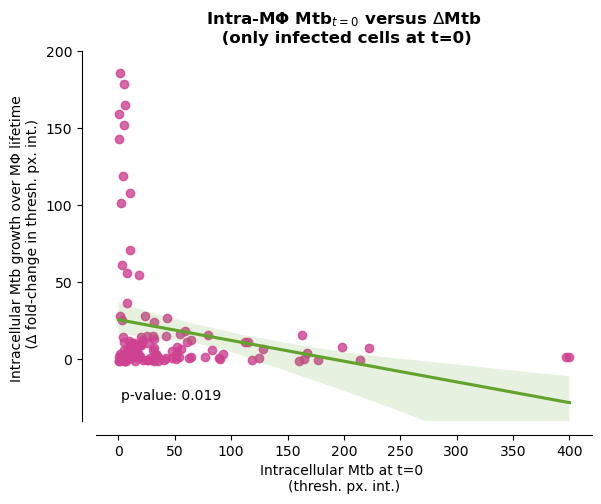

In [47]:

# Filter the DataFrame for Time (hours) == 0 and non-zero initial Mtb load
subset_df = df[(df['Time_hours'] == 0) & (df['Intracellular_thresholded_Mtb_content'] != 0)][['Intracellular_thresholded_Mtb_content', 'delta_Mtb_foldchange']]

# Plot the scatter plot with a line of best fit
reg_plot = sns.regplot(data=subset_df, x='Intracellular_thresholded_Mtb_content',
                       y='delta_Mtb_foldchange', color=colors[0], 
                       line_kws={'color': colors[-1]})

# Set the axis labels and title
plt.xlabel('Intracellular Mtb at t=0 \n(thresh. px. int.)')
plt.ylabel('Intracellular Mtb growth over MΦ lifetime \n (Δ fold-change in thresh. px. int.)')
plt.title('Intra-MΦ Mtb$_{t=0}$ versus $\Delta$Mtb \n (only infected cells at t=0)', fontweight='bold')

sns.despine(offset=10)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_df['Intracellular_thresholded_Mtb_content'],
                                                               subset_df['delta_Mtb_foldchange'])

# Add the p-value to the plot
reg_plot.text(0.05, 0.05, f'p-value: {p_value:.3f}', ha='left', va='bottom', transform=reg_plot.transAxes)

plt.ylim(-40, 200)
# Modify y-axis tick labels to show only positive values
plt.yticks([tick for tick in plt.yticks()[0] if tick >= 0])

# plt.savefig(os.path.join(output_dir, 'initial_load_growth_correlation/fold_change_infected_cells.png'), bbox_inches='tight', dpi=314)

# Show the plot
plt.show()

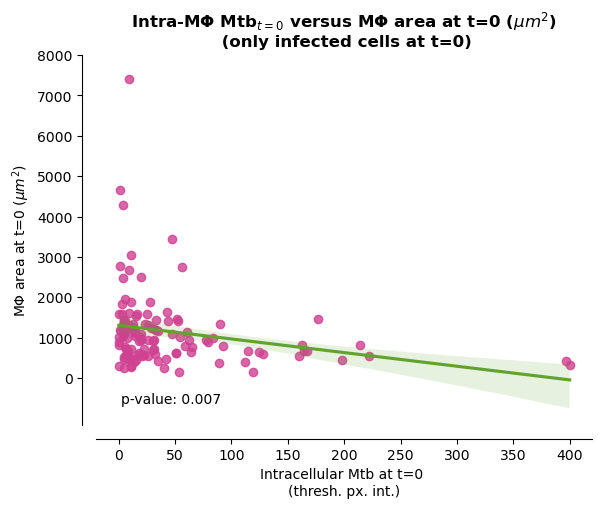

In [48]:

# Define another parameter to measure
other_param = 'Area'

# Filter the DataFrame for Time (hours) == 0 and non-zero initial Mtb load
subset_df = df[(df['Time_hours'] == 0) & (df['Intracellular_thresholded_Mtb_content'] != 0)][['Intracellular_thresholded_Mtb_content', other_param]]

# Scale area, 1m2 to 1um2 * 1E6**2
scale_factor = 1.4949402023919043E-7
subset_df['Area'] = (subset_df['Area'] * scale_factor**2) * 1E6**2

# Plot the scatter plot with a line of best fit
reg_plot = sns.regplot(data=subset_df, x='Intracellular_thresholded_Mtb_content',
                       y=other_param, color=colors[0],
                       line_kws={'color': colors[-1]})

# Set the axis labels and title
plt.xlabel('Intracellular Mtb at t=0 \n(thresh. px. int.)')
plt.ylabel('MΦ area at t=0 ($\mu {m}^2$)')
plt.title('Intra-MΦ Mtb$_{t=0}$ versus MΦ area at t=0 ($\mu {m}^2$) \n (only infected cells at t=0)', fontweight='bold')

# Remove the top and right spines
sns.despine(offset=10)

# Perform linear regression using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = stats.linregress(subset_df['Intracellular_thresholded_Mtb_content'], subset_df[other_param])

# Add the p-value to the plot
reg_plot.text(0.05, 0.05, f'p-value: {p_value:.3f}', ha='left', va='bottom', transform=reg_plot.transAxes)

# # Set the y-axis limits
# plt.ylim(-40, 200)

# Modify y-axis tick labels to show only positive values
plt.yticks([tick for tick in plt.yticks()[0] if tick >= 0])

# Define a title
fn_title = 'area_t0_Mtb_t0'
# # Save the plot
# plt.savefig(os.path.join(output_dir, f'initial_load_growth_correlation/{fn_title}.png'), bbox_inches='tight', dpi=314)

# Show the plot
plt.show()

In [50]:
df

,Time_hours,x,y,x_scaled,y_scaled,Infection_status,Initial_infection_status,Final_infection_status,Area,Intracellular_mean_Mtb_content,Intracellular_thresholded_Mtb_content,Macroph_GFP_expression,delta_Mtb,delta_Mtb_foldchange,Eccentricity,MSD,Strain,Compound,Concentration,Cell_ID,Acquisition_ID,Unique_ID
0,0,723.909912,33.010132,3648.505957,166.371064,Infected,Infected,Infected,23203.0,357.706421,4.649916,887.426208,26.188255,5.631984,0.967023,0.000000,WT,CTRL,EC0,423,"(3, 5)",423.3.5
1,1,727.771362,38.211437,3667.967666,192.585644,Infected,Infected,Infected,25659.0,363.283356,8.909817,1602.132080,26.188255,5.631984,0.972516,6.477992,WT,CTRL,EC0,423,"(3, 5)",423.3.5
2,2,730.887634,26.283424,3683.673677,132.468459,Infected,Infected,Infected,19483.0,355.947845,7.153211,1095.762207,26.188255,5.631984,0.948291,12.328367,WT,CTRL,EC0,423,"(3, 5)",423.3.5
3,3,732.147583,27.895367,3690.023818,140.592648,Infected,Infected,Infected,22840.0,354.730682,6.231918,953.190063,26.188255,5.631984,0.958847,2.045930,WT,CTRL,EC0,423,"(3, 5)",423.3.5
4,4,730.891357,33.019173,3683.692441,166.416630,Infected,Infected,Infected,23224.0,356.257538,8.091026,995.672668,26.188255,5.631984,0.976475,5.275556,WT,CTRL,EC0,423,"(3, 5)",423.3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22813,70,11.404111,928.200378,57.476719,4678.129907,Infected,Uninfected,Infected,15506.0,437.055450,116.548302,2788.570068,94.672058,inf,0.863828,2.616289,WT,CTRL,EC0,3380,"(3, 5)",3380.3.5
22814,71,6.907405,927.155212,34.813321,4672.862271,Uninfected,Uninfected,Infected,5796.0,342.371277,0.000000,2744.147217,94.672058,inf,0.853696,4.616572,WT,CTRL,EC0,3380,"(3, 5)",3380.3.5
22815,72,9.546013,927.389832,48.111905,4674.044751,Infected,Uninfected,Infected,12314.0,399.863647,73.398003,2788.622559,94.672058,inf,0.866145,2.649018,WT,CTRL,EC0,3380,"(3, 5)",3380.3.5
22816,73,8.320204,924.214172,41.933827,4658.039429,Infected,Uninfected,Infected,10518.0,407.069397,79.124168,2974.992676,94.672058,inf,0.803451,3.404030,WT,CTRL,EC0,3380,"(3, 5)",3380.3.5


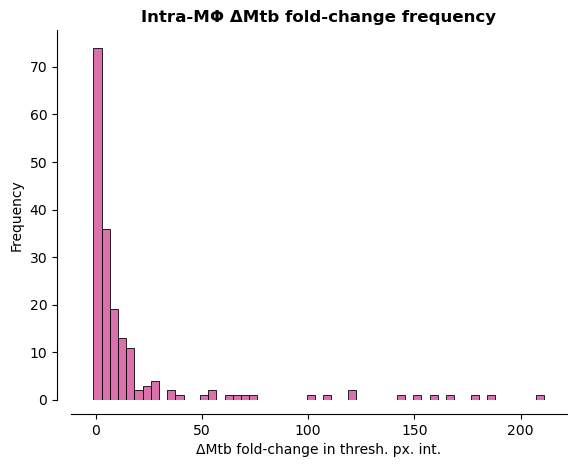

In [51]:
sns.histplot(df['delta_Mtb_foldchange'].unique(), color=(0.8129181084198386,
  0.2544405997693195,
  0.5693194925028835))

sns.despine(offset = 10)

# Set the axis labels and title
plt.xlabel('ΔMtb fold-change in thresh. px. int.')
plt.ylabel('Frequency')
plt.title(f'Intra-MΦ ΔMtb fold-change frequency', fontweight='bold')
# Define a title
fn_title = 'distribution_delta_mtb_foldchange'
# Save the plot
# plt.savefig(os.path.join(output_dir, f'initial_load_growth_correlation/{fn_title}.png'), bbox_inches='tight', dpi=314)


# Animating these graphs (making interactive)

In [183]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, output_file, ColumnDataSource, output_notebook
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
from bokeh.models import WheelZoomTool
from bokeh.plotting import save
import matplotlib.cm as cm


In [53]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [77]:
subset_df = df[(df['Time_hours'] == 0) & (df['Intracellular_thresholded_Mtb_content'] != 0)]

# Trying with scatter

In [80]:
subset_df['delta_Mtb_norm'] = subset_df['delta_Mtb']/subset_df['Area']

In [178]:
subset_df['area_point_size'] = subset_df['Area']/1E4/2

In [82]:
subset_df['Color_codes'] = [(120, 197, 120) if infected == 'Uninfected' else (230, 97, 135) for infected in subset_df['Final_infection_status']]
subset_df['Color_codes'] = pd.Series(subset_df['Color_codes'])

In [187]:
# Define the colormap and normalize the eccentricity values
cmap = cm.get_cmap('PiYG')
norm = plt.Normalize(vmin=subset_df['Eccentricity'].min(), vmax=subset_df['Eccentricity'].max())
# Create the "eccentricity_color_codes" column with RGB values
subset_df['eccentricity_color_codes'] = [
    tuple(int(255 * c) for c in cmap(norm(eccentricity))[:3])
    for eccentricity in subset_df['Eccentricity']
]

In [211]:
subset_df

,Time_hours,x,y,x_scaled,y_scaled,Infection_status,Initial_infection_status,Final_infection_status,Area,Intracellular_mean_Mtb_content,Intracellular_thresholded_Mtb_content,Macroph_GFP_expression,delta_Mtb,delta_Mtb_foldchange,Eccentricity,MSD,Strain,Compound,Concentration,Cell_ID,Acquisition_ID,Unique_ID,delta_Mtb_norm,area_point_size,Color_codes,glimpse_url,eccentricity_color_codes
0,0,723.909912,33.010132,3648.505957,166.371064,Infected,Infected,Infected,23203.0,357.706421,4.649916,887.426208,26.188255,5.631984,0.967023,0.0,WT,CTRL,EC0,423,"(3, 5)",423.3.5,0.001129,1.16015,"(230, 97, 135)","https://macrohet.s3.eu-west-2.amazonaws.com/3,...","(53, 118, 28)"
75,0,1182.075928,41.261177,5957.662676,207.956332,Infected,Infected,Infected,46389.0,337.410736,3.395546,1146.479980,4.765842,1.403557,0.816728,0.0,WT,CTRL,EC0,414,"(3, 5)",414.3.5,0.000103,2.31945,"(230, 97, 135)","https://macrohet.s3.eu-west-2.amazonaws.com/3,...","(180, 222, 129)"
386,0,743.379944,86.152077,3746.634917,434.206467,Infected,Infected,Infected,7163.0,401.207581,53.289265,3329.977295,87.236370,1.637035,0.643778,0.0,WT,CTRL,EC0,424,"(3, 5)",424.3.5,0.012179,0.35815,"(230, 97, 135)","https://macrohet.s3.eu-west-2.amazonaws.com/3,...","(252, 227, 240)"
436,0,53.606846,33.602959,270.178503,169.358912,Infected,Infected,Infected,39536.0,345.527985,0.322617,1557.244141,46.160995,143.082802,0.906845,0.0,WT,CTRL,EC0,425,"(3, 5)",425.3.5,0.001168,1.97680,"(230, 97, 135)","https://macrohet.s3.eu-west-2.amazonaws.com/3,...","(97, 163, 46)"
470,0,897.140137,30.198242,4521.586289,152.199141,Infected,Infected,Infected,24500.0,382.882935,20.295877,2503.944336,285.504385,14.067112,0.593675,0.0,WT,CTRL,EC0,426,"(3, 5)",426.3.5,0.011653,1.22500,"(230, 97, 135)","https://macrohet.s3.eu-west-2.amazonaws.com/3,...","(244, 194, 224)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14461,0,252.233109,1136.251221,1271.254867,5726.706152,Infected,Infected,Infected,192146.0,375.402252,4.035587,2429.398682,14.005545,3.470510,0.811456,0.0,WT,CTRL,EC0,194,"(3, 5)",194.3.5,0.000073,9.60730,"(230, 97, 135)","https://macrohet.s3.eu-west-2.amazonaws.com/3,...","(184, 225, 135)"
14709,0,902.524475,1125.607544,4548.723354,5673.062021,Infected,Infected,Infected,52004.0,375.076599,1.924621,3060.895508,195.435486,101.544909,0.931300,0.0,WT,CTRL,EC0,164,"(3, 5)",164.3.5,0.003758,2.60020,"(230, 97, 135)","https://macrohet.s3.eu-west-2.amazonaws.com/3,...","(76, 145, 32)"
15200,0,669.187439,1166.362183,3372.704692,5878.465400,Infected,Infected,Infected,59731.0,368.285675,4.398051,1930.707520,62.882459,14.297800,0.848261,0.0,WT,CTRL,EC0,218,"(3, 5)",218.3.5,0.001053,2.98655,"(230, 97, 135)","https://macrohet.s3.eu-west-2.amazonaws.com/3,...","(149, 202, 92)"
15544,0,195.614960,1134.595581,985.899397,5718.361729,Infected,Infected,Infected,56817.0,375.205444,5.526568,1669.304443,18.090797,3.273423,0.951523,0.0,WT,CTRL,EC0,197,"(3, 5)",197.3.5,0.000318,2.84085,"(230, 97, 135)","https://macrohet.s3.eu-west-2.amazonaws.com/3,...","(62, 128, 30)"


In [207]:
from bokeh.models import Label





In [223]:
# Define the tools for the plot
TOOLS = "crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,help"

# Create the figure
p = figure(tools=TOOLS, plot_width=900, plot_height=600)
p.toolbar.active_scroll = p.select_one(WheelZoomTool)

# Add scatter points to the plot
p.scatter(source=ColumnDataSource(subset_df),
          x='Intracellular_thresholded_Mtb_content',
          y='delta_Mtb_foldchange',
          radius='area_point_size',
          fill_color='eccentricity_color_codes',
          fill_alpha=0.7,
          line_color=None,
          
          )

# Configure the hover tool for tooltips
hover = HoverTool(
    tooltips="""
        <div>
            <div>
                <img
                    src="@glimpse_url" height="120" alt="@glimpse_url" width="120"
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                ></img>
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold; color: black;">Cell ID: @Cell_ID</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">ΔMtb: @delta_Mtb_foldchange</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Area: @Area</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Eccentricity: @Eccentricity</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Strain: @Strain</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Compound: @Compound</span>
            </div>
            <div>
                <span style="font-size: 15px; color: black;">Concentration: @Concentration</span>
            </div>
        </div>
    """
)

# Add the hover tool to the plot
p.add_tools(hover)

# Configure the plot axes and title
p.xaxis.axis_label = 'Intra-MΦ Mtb load at t=0 \n(thresholded pixel intensity)'
p.yaxis.axis_label = 'Intracellular ΔMtb growth over MΦ lifetime \n (fold-change in thresholded pixel intensity)'
p.title.text = 'Is the intra-macrophage Mtb load at t=0 correlated to subsequent Mtb growth?'
p.title.align = 'center'
p.title.text_font_size = '13pt'
p.title.text_font_style = 'bold'

# # Create the legend for point size and color
# p.legend.title = "Legend"
# p.legend.location = "top_right"
# p.legend.label_text_font_size = "10pt"
# p.legend.label_text_color = "black"

# p.legend.items = [
#     ("Area", ["area_point_size"]),
#     ("Eccentricity", ["eccentricity_color_codes"]),
# ]
mytext = Label(x=100, y=60, background_fill_alpha = 0.5, background_fill_color = (140, 191, 38),
               text='Point size represents cell area')
mytext2 = Label(x=100, y=50, background_fill_alpha = 0.5, background_fill_color = (197, 27, 125),
               text='Point colour represents cell eccentricity')
mytext3 = Label(x=270, y=15, background_fill_alpha = 0.5, background_fill_color = (211, 211, 211),
               text='Try panning and zooming to \ninspect single-cell outliers')
p.add_layout(mytext3)
p.add_layout(mytext)
p.add_layout(mytext2)

# Specify the output file path and filename
output_file_path = "/home/dayn/analysis/macrohet/downstream_analysis/plotting/interactive_plot_glimpses/3,5_deltaMtb_v_mtb_t0.html"

# Save the plot as an HTML file
save(p, filename=output_file_path)

# Show the plot
# show(p)


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/bokeh/io/saving.py:142: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/bokeh/io/saving.py:154: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/home/dayn/analysis/macrohet/downstream_analysis/plotting/interactive_plot_glimpses/3,5_deltaMtb_v_mtb_t0.html'

In [210]:
help(Label)

Help on class Label in module bokeh.models.annotations:

class Label(TextAnnotation)
 |  Label(*args, **kwargs) -> 'Model'
 |  
 |  Render a single text label as an annotation.
 |  
 |  ``Label`` will render a single text label at given ``x`` and ``y``
 |  coordinates, which can be in either screen (pixel) space, or data (axis
 |  range) space.
 |  
 |  The label can also be configured with a screen space offset from ``x`` and
 |  ``y``, by using the ``x_offset`` and ``y_offset`` properties.
 |  
 |  Additionally, the label can be rotated with the ``angle`` property.
 |  
 |  There are also standard text, fill, and line properties to control the
 |  appearance of the text, its background, as well as the rectangular bounding
 |  box border.
 |  
 |  See :ref:`userguide_annotations_labels` for information on plotting labels.
 |  
 |  Method resolution order:
 |      Label
 |      TextAnnotation
 |      Annotation
 |      bokeh.models.renderers.Renderer
 |      bokeh.model.model.Model
 | 

In [152]:
subset_df[subset_df['Cell_ID'] == 247]

,Time_hours,x,y,x_scaled,y_scaled,Infection_status,Initial_infection_status,Final_infection_status,Area,Intracellular_mean_Mtb_content,Intracellular_thresholded_Mtb_content,Macroph_GFP_expression,delta_Mtb,delta_Mtb_foldchange,Eccentricity,MSD,Strain,Compound,Concentration,Cell_ID,Acquisition_ID,Unique_ID,delta_Mtb_norm,area_point_size,Color_codes,glimpse_url
12839,0,1058.908691,996.020752,5336.899805,5019.94459,Infected,Infected,Infected,54849.0,378.471191,7.365804,1909.003418,265.676066,36.068847,0.924238,0.0,WT,CTRL,EC0,247,"(3, 5)",247.3.5,0.004844,5.4849,"(230, 97, 135)",https://github.com/nthndy/macrohet/blob/main/d...


# Adding images

Also the above needs fixing in some slight ways...

In [18]:
from macrohet import tile, dataio

In [16]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


In [19]:
image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
#                              set_channel=1,
#                              set_time = 1,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()

In [139]:
for cell_ID in tqdm(subset_df['Cell_ID']):
    glimpse = animated_plot_glimpse_maker(images, cell_ID, subset_df)
    output_fn = f'/mnt/DATA/macrohet/results/glimpses/interactive_plots/{row},{column}/glimpse_{cell_ID}.{row}.{column}_t0.png'
    io.imsave(output_fn, glimpse)

  0%|          | 0/123 [00:00<?, ?it/s]

# Add URL of images to subset_df

In [157]:
# Create a new column 'glimpse_url' with default values of None
subset_df['glimpse_url'] = None

# Iterate over the rows of the subset_df DataFrame
for index, row_ in subset_df.iterrows():
    cell_ID = row_['Cell_ID']
    online_fn = f'https://macrohet.s3.eu-west-2.amazonaws.com/{row},{column}/glimpse_{cell_ID}.{row}.{column}_t0.png'
#     output_fn = f'/mnt/DATA/macrohet/results/glimpses/interactive_plots/{row},{column}/glimpse_{cell_ID}.{row}.{column}_t0.png'
    subset_df.at[index, 'glimpse_url'] = online_fn


In [155]:
online_fn

'https://github.com/nthndy/macrohet/blob/main/downstream_analysis/plotting/interactive_plot_glimpses/3%2C5/glimpse_210.3.5_t0.png'

In [225]:
1.4949402023919043E-7*6048*1E6

904.1398344066238